In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import t, f, norm
from sklearn.neighbors import KNeighborsClassifier

In [22]:
N = 50
np.random.seed(42)
X = [] # выборка
for i in range(N):
    y = np.random.uniform(-1, 1, 5)
    y = np.append(y, np.random.normal(2+3*y[0]-2*y[1]+y[2]+y[3]-y[4], 1.5))
    X.append(y)

In [48]:
# проверка на мультиколлинеарность
data = pd.DataFrame(X, columns = ['x0','x1','x2','x3','x4','etta'])
data.head(5)

,x0,x1,x2,x3,x4,etta
0,-0.250920,0.901429,0.463988,0.197317,-0.687963,1.212213
1,0.416145,-0.958831,0.939820,0.664885,-0.575322,8.861897
2,-0.636350,-0.633191,-0.391516,0.049513,-0.136110,2.376107
3,-0.721012,-0.415711,-0.267276,-0.087860,0.570352,-2.542918
4,-0.600652,0.028469,0.184829,-0.907099,0.215090,-1.696636


In [24]:
cols = ['x0','x1','x2','x3','x4']
X_train = data.drop(['eta'], axis = 1)
y_train = data[['eta']].values
y_ = np.mean(y_train)
for i in cols:
    x = X_train[[i]].values
    clf = LinearRegression()
    clf.fit(x, y_train)
    pr = clf.predict(x)
    e = y_train - pr
    RSS = e.T@e
    TSS = np.sum((y_train - y_)**2)
    R = 1 - RSS/TSS
    print(i, ': ', np.around(R[0][0], 3))

x0 :  0.478
x1 :  0.133
x2 :  0.075
x3 :  0.09
x4 :  0.104


## не мультиколлинеарны

In [25]:
# уравнение линейной регрессии и значимость коэффициентов
data.insert(0, '1', 1)
psi = data.drop(['eta'], axis = 1).values
F = psi.T@psi
f_i = np.linalg.inv(F)
b = f_i@psi.T@y_train
e = y_train - psi@b
RSS = e.T@e
deltas = []
for i in range(6):
    deltas.append(b[i][0]/(np.sqrt(RSS/44*f_i[i][i])))

for i in range(6):
    print('дельта', i, ':', np.around(deltas[i][0][0], 3), '    b', i, ':', np.around(b[i][0], 3))
    
p_valueb = [abs(2*(1 - t.cdf(abs(d),44))) for d in deltas]
np.around(p_valueb, 3).T

if (p_value < 0.05):
    print(f'p-value = {p_value} => отвергаем Н0')
else:
    print(f'p-value = {p_value} => нет оснований отвергнуть Н0')

дельта 0 : 9.072     b 0 : 1.94
дельта 1 : 7.283     b 1 : 2.34
дельта 2 : -5.316     b 2 : -1.966
дельта 3 : 3.735     b 3 : 1.328
дельта 4 : 3.582     b 4 : 1.361
дельта 5 : -4.786     b 5 : -1.808
p-value = 9.999999999998899e-05 => отвергаем Н0


In [26]:
# коэффициент детерминации и его значимость
TSS = np.sum((y_train - y_)**2)
R2 = 1 - RSS/TSS
delta = R2/(1-R2)*44/5
delta = delta[0][0]
p_value = abs((1 - f.cdf(delta, 5,44)))
if (p_value < 0.05):
    print(f'p-value = {p_value} => отвергаем Н0 и коэфф детерминации значим')
else:
    print(f'p-value = {p_value} => нет оснований отвергнуть Н0')

p-value = 1.4921397450962104e-13 => отвергаем Н0 и коэфф детерминации значим


In [27]:
# 95% доверительныый интервал
x_0 = np.zeros_like(b.T)
x_0[0] = 1

y_pr = x_0@b
eps = 10e-6
ta = 0
for i in list(np.linspace(2, 5, 50000)):
    if (abs(t.cdf(i, 44) - 0.975)<eps):
        ta = i
        break

s = np.sqrt(RSS*(1 + x_0@f_i@x_0.T)/44)
l = np.around(float(y_pr - ta*s), 3)
r = np.around(float(y_pr + ta*s), 3)
print(f'Доверительный интервал = [{l}; {r}]')

Доверительный интервал = [-0.052; 6.444]


In [28]:
# независимость ошибок измерения
I = np.sum(np.sum(e[i]<e[:i]) for i in range(len(e)))
delta = (I - N*(N-1)/4)/np.sqrt((N**3)/36)
p_value = 2*(1 - norm.cdf(delta))
if (p_value < 0.05):
    print(f'p-value = {p_value} => отвергаем Н0')
else:
    print(f'p-value = {p_value} => нет оснований отвергнуть Н0\n')

p-value = 0.35502017927847085 => нет оснований отвергнуть Н0



C:\Users\karsa\AppData\Local\Temp/ipykernel_5696/3585904908.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  I = np.sum(np.sum(e[i]<e[:i]) for i in range(len(e)))


p-value = 9.999999999998899e-05 => отвергаем Н0


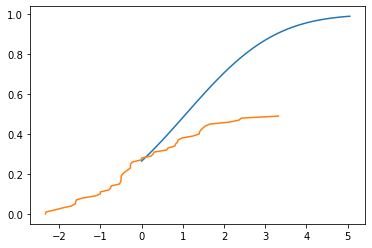

In [29]:
# нормальность распределения ошибок
n = 100
e_ = np.ravel(e)
m = np.mean(abs(e_))
s = np.var(e_)
x = np.linspace(np.min(e), np.max(e), n)
y_e = [np.sum(e_<i)/n for i in np.sort(e_)]
y_emp = [norm.cdf(i, m, s) for i in np.sort(e_)]

delta_acc = n**0.5*max(list(map(lambda x,y: abs(x-y), y_e, y_emp)))

# расчет p-value

N1 = 10000

d_k = []
for i in range(N1):
    norm_ = np.random.normal(m, s, N)
    x = np.linspace(0, max(norm_), 100)
    f1 = [np.sum(norm_<i)/N for i in x]
    f2 = [np.sum(e<i)/N for i in x]
    res = N**0.5*max(list(map(lambda x,y: abs(x-y), f1, f2)))
    d_k.append(res)
    
d_v = np.sort(d_k)
k = len(d_v[d_v<delta_acc])
p_value = 1-((k-1)/N1)

if (p_value < 0.05):
    print(f'p-value = {p_value} => отвергаем Н0')
else:
    print(f'p-value = {p_value} => нет оснований отвергнуть Н0\n')

plt.plot(x, norm.cdf(x, m, s))
plt.plot(np.sort(e_), y_e)

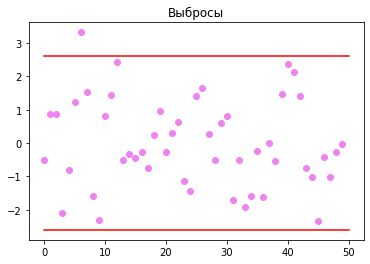

Выброс: 3.3209221663172017


In [33]:
# исследование регрессии на выбросы
sigma = np.median(abs(e))/0.675

#построение

plt.plot([0,50], [2*sigma, 2*sigma], color = 'r')
plt.plot([0,50], [-2*sigma, -2*sigma], color = 'r')
plt.scatter(np.arange(N), e, color = 'violet')
plt.title("Выбросы")
plt.show()

ind = 0
for i in range(N):
    if(e[i] > 2*sigma):
        print(f'Выброс: {e[i][0]}')
        break

In [34]:
# кросс-проверка регрессии
X_train = data.drop(['1','eta'], axis = 1)
y_train = data[['eta']]
cv = []

for i in range(N):
    X_test = X_train.loc[i].values
    y_test = y_train.loc[i].values
    X_train1 = X_train.drop(i, axis = 0).values
    y_train1 = y_train.drop(i, axis = 0).values
    F = X_train1.T@X_train1
    F_i = np.linalg.inv(F)
    b1 = F_i@X_train1.T@y_train1
    pr1 = X_test@b1
    e = y_test - pr1
    cv.append(e**2)
    
cv = np.array(cv)
cvss = np.sum(cv)
R2_cv = 1 - cvss/TSS
print('R2 = ', R2_cv)

R2 =  0.21541033693401868


In [36]:
# првоерка адекватности регрессии с помощью 5 повторных измерений в одной точке
psi5 = np.random.uniform(-1, 1, 5)
eta5 = np.random.normal(2+3*psi5[0]-2*psi5[1]+psi5[2]+psi5[3]-psi5[4], 1.5, 5)
sigma5 = 0.25*np.sum((eta5 - np.mean(eta5))**2)
delta5 = RSS/(44*sigma5)
p_value5 = 1 - f.cdf(delta5,  44, 4)

if (p_value5[0][0] < 0.05):
    print(f'p-value = {p_value5[0][0]} => отвергаем Н0')
else:
    print(f'p-value = {p_value5[0][0]} => нет оснований отвергнуть Н0 => модель адекватна\n')

p-value = 0.8263092059934734 => нет оснований отвергнуть Н0 => модель адекватна



In [44]:
# повторение пунктов b и c + сравнение уравнений регрессии
indr = np.argmax(p_valb)

dt = data.drop(['x'+str(indr)], axis = 1)
psi1 = data.drop(['eta'], axis = 1).values
y_train1 = dt[['eta']].values
F1 = psi1.T@psi1
F_i = np.linalg.inv(F1)
b1 = F_i@psi1.T@y_train1
e1 = y_train1 - psi1@b1
RSS1 = e1.T@e1
delta1 = []
for i in range(5):
    delta1.append(b1[i][0]/(np.sqrt(RSS1/43*F_i[i][i])))

for i in range(5):
    print('дельта', i, ':', np.around(delta1[i][0][0], 3),
          '    b', i, ':', np.around(b1[i][0], 3))
    
p_value1 = [abs(2*(1 - t.cdf(abs(d),43))) for d in delta1]
for i in range(0, 5):
    if (p_value1[i] < 0.05):
        print(f'p-value = {p_value1[i]} => отвергаем Н0 для коэффициента {i+1}')
    else:
        print(f'p-value = {p_value1[i]} => нет оснований отвергнуть Н0 для коэффицента {i+1} => коэффициент регрессии {i+1} значим\n')

дельта 0 : 8.968     b 0 : 1.94
дельта 1 : 7.2     b 1 : 2.34
дельта 2 : -5.256     b 2 : -1.966
дельта 3 : 3.692     b 3 : 1.328
дельта 4 : 3.541     b 4 : 1.361
p-value = [[2.11328732e-11]] => отвергаем Н0 для коэффициента 1
p-value = [[6.61309918e-09]] => отвергаем Н0 для коэффициента 2
p-value = [[4.36549491e-06]] => отвергаем Н0 для коэффициента 3
p-value = [[0.00062292]] => отвергаем Н0 для коэффициента 4
p-value = [[0.00097204]] => отвергаем Н0 для коэффициента 5


In [46]:
y_1 = np.mean(y_train1)
TSS1 = np.sum((y_train1 - y_1)**2)
R2_ = 1 - RSS1/TSS1
print('R2:', R2_[0][0])
delta1 = R2_/(1-R2_)*43/4
delta1 = delta1[0][0]

p_value = abs((1 - f.cdf(delta1, 4,43)))
if (p_value < 0.05):
    print(f'p-value = {p_value} => отвергаем Н0 => коэфф регрессии значим')
else:
    print(f'p-value = {p_value} => нет оснований отвергнуть Н0')

R2: 0.7830599204052122
p-value = 9.603429163007604e-14 => отвергаем Н0 => коэфф регрессии значим


In [47]:
# сравнение уравнений регрессии бустрапом
deltab = (RSS - RSS1)/RSS1*(N - len(b))/(len(b) - len(b1))

n = 10000
d_b = []
for i in range(n):
    dt = data.loc[np.random.randint(0,len(data),len(data))]
    dt1 = dt.drop(['x'+str(indr)], axis = 1)
    x = dt.drop('eta', axis = 1)
    x1 = dt1.drop('eta', axis = 1)
    y = dt['eta']
    y1 = dt1['eta']
    
    F0 = x.T @ x
    F1 = x1.T @ x1
    F0_i = np.linalg.inv(F0) 
    F1_i = np.linalg.inv(F1) 
    b_0 = F0_i @ x.T @ y
    b_1 = F1_i @ x1.T @ y1 
    y_pr = x @ np.ravel(b_0)
    y_pr1 = x1 @ np.ravel(b_1)  
    e_ = y - y_pr
    e_1 = y1 - y_pr1  
    RSS_ = e_.T @ e_
    RSS_1 = e_1.T @ e_1
    d = (RSS_ - RSS_1)/RSS_1*(N - len(b_0))/(len(b_0) - len(b_1))
    d_b.append(d)
    
deltas = np.sort(d_b)
k = len(deltas[deltas<d_b])
p_value = 1-((k-1)/n)
if (p_value < 0.05):
    print(f'p-value = {p_value} => отвергаем Н0')
else:
    print(f'p-value = {p_value} => нет оснований отвергнуть Н0\n')

C:\Users\karsa\AppData\Local\Temp/ipykernel_5696/3869053566.py:2: RuntimeWarning: invalid value encountered in true_divide
  deltab = (RSS - RSS1)/RSS1*(N - len(b))/(len(b) - len(b1))


p-value = 0.5005 => нет оснований отвергнуть Н0

